In [278]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from numba import jit
from matplotlib_scalebar.scalebar import ScaleBar
path_figs = 'Figs/'

visual_drift_coef = 1
visual_drift_min = 0.8
memory_drift_coef = 0.7
memory_drift_adaptive_coef_activation = 0.3
memory_drift_adaptive_coef_deactivation = 0.9
visual_drift_adaptive_coef = 0

In [279]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result


def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [280]:
# seq = '13524232514111'
# specific_seq = '13524232514111'
# random_seq = '45341323141322'
# specific_seq_changed = '13524223141322'
# specific_seq_changed_one_digit = '13524212514111'

seq = '1352423'
specific_seq = '1352423'
random_seq = '4534132'
# specific_seq_changed = '1352423'
specific_seq_changed_one_digit = '1353423'

seq_length = len(seq)
window_sizes = [1,2,3,7]

visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

visual_delay = 90
motor_delay = 50

diffusion = 3
threshold = 310
alpha = 0.9985
beta = 0.0005

# param = [0.80456878, 0.36385731, 0.75921864, 0.36382248, 0.17006857,
#        0.72666298, 0.36340774, 0.16293408, 0.07705195]


# param = [0.81403939, 0.39269762, 0.78576587, 0.39263559, 0.1590846 ,
#        0.78171855, 0.39182347, 0.13888817, 0.05866263]


# param = [0.80546286, 0.34406671, 0.77078511, 0.34047097, 0.17400204,
#        0.76927114, 0.33807873, 0.16315422, 0.08028436]


# param = [0.75295921, 0.50182646, 0.73406735, 0.45987093, 0.34447993,
#         0.69723121, 0.41742494, 0.2493258 , 0.24174475]


param = [0.782587,  0.4290474,  0.7447472,  0.4274116,  0.31541915]

In [260]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")

@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    theta = np.zeros(capacity)
    
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = param[1]
    elif capacity >= 3:
        theta[0] = param[2]
        theta[1] = param[3]
        theta[2] = param[4]

    return theta
    
@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    # theta /= np.sum(theta)
    return theta

def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

def calculate_IPI_from_press_time(press_times):

   return np.array([press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))])

In [261]:
@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time, 
                 seq_length, window_size, planning_capacity, planning_param, planning_strategy, visual_delay, motor_delay, alpha, beta, memory_drift_coef):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length), dtype=float)
    motor_delay_queue = np.zeros(0, dtype=float)
    current_press_planned = 0
    current_press_execed = 0

    current_memory_coef = memory_drift_coef
    current_visual_coef = visual_drift_coef

    effective_planning_capacity = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)
    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta


    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        evidence[:, current_press_planned:] += diffusion_term * random_terms[:, current_press_planned:, t_index]

        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] * current_visual_coef
            
            if press == current_press_planned:
                evidence[:, current_press_planned] += drifts_memory_dt[:, current_press_planned] * current_memory_coef

        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])
            
        if (evidence[:, current_press_planned: current_press_planned + 1] >= threshold).any():
            visible_window_size -= 1
            current_press_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time

            if seq[current_press_execed] == specific_seq[current_press_execed]:
                current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
            else:
                current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef

            current_press_execed += 1
            
            if current_press_execed == seq_length:
                break   

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    return press_times, evidence

In [275]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3,  
                 planning_strategy = 0, visual_delay = visual_delay, motor_delay = motor_delay,  alpha = 0.995, beta = 0.001, memory_drift_coef = 0.7):
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta

        self.memory_drift_coef = memory_drift_coef
    

    def simulate(self):
        press_times, evidence = simulate_ddm(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts,
                                              self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, 
                                              self.window_size, self.planning_capacity, self.planning_param, 
                                              self.planning_strategy, self.visual_delay, self.motor_delay, self.alpha, self.beta, self.memory_drift_coef)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(5,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length), dtype=float)
        motor_delay_queue = np.array([], dtype=float)
        current_press_planned = 0
        current_press_execed = 0

        current_memory_coef = memory_drift_coef
        current_visual_coef = visual_drift_coef

        effective_planning_capacity = 0
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        visible_window_size = 0

        press_times = np.full(seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)

        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            if len(motor_delay_queue) > 0:
                motor_delay_queue[0] += self.dt


            evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
            evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
            evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]

            for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + effective_planning_capacity)):
                for finger in range(5):
                    evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 

                if press == current_press_planned:
                        for finger in range(5):
                            evidence[finger, current_press_planned] += self.memory_drifts[finger, current_press_planned] * self.dt * current_memory_coef
                
                evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])

            for press in range(0, self.seq_length):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])


            if (evidence[:, current_press_planned: current_press_planned + 1] >= self.threshold).any():
                visible_window_size -= 1
                current_press_planned += 1
                motor_delay_queue = np.append(motor_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
            
            if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                motor_delay_queue = motor_delay_queue[1:]
                visual_delay_queue = np.append(visual_delay_queue, 0)
                press_times[current_press_execed] = time

                if self.seq[current_press_execed] == self.specific_seq[current_press_execed]:
                    current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                    current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                else:
                    current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                    current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                # print("current memory: ", current_memory_coef)
                # print("current vision: ", current_visual_coef)

                current_press_execed += 1

                if current_press_planned == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
            

        for press in range(self.seq_length):
            for finger in range(5):
                sns.lineplot(x = np.arange(0, np.round(time, 2), self.dt), y = evidence_over_time[finger, press, :t_index], ax = axs[press], linestyle = '-',
                              label = f'Finger {finger+1}')
            axs[press].set_xlim([0, np.round(time, 2)])
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            axs[press].set_ylabel('Evidence')
            axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            axs[press].set_yticks([0, 350])
            axs[press].set_xlim([0, 5000])

            axs[press].tick_params(axis='x', labelrotation=45)
            axs[press].set_title(f'Press {press + 1}')
            axs[press].legend(loc = 'upper right')
        
        sns.despine(trim = True)
        plt.tight_layout()
        # plt.savefig(path_figs + "Horse_Race.pdf", format = 'pdf', bbox_inches = 'tight')
        plt.show()
        return fig, axs
    


    def plot_average_simulations(self, num_simulations):
        
        fig, axs = plt.subplots(self.seq_length, figsize=(5,20))
        all_evidence = np.zeros((num_simulations, 5, self.seq_length, int(self.max_time/self.dt)))

        for _ in range(num_simulations):
            evidence = np.zeros((5, self.seq_length))
            evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
            time = 0
            t_index = 0
            visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length), dtype=float)
            motor_delay_queue = np.array([], dtype=float)
            current_press_planned = 0
            current_press_execed = 0

            current_memory_coef = memory_drift_coef
            current_visual_coef = visual_drift_coef

            effective_planning_capacity = 0
            planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
            visible_window_size = 0

            press_times = np.full(seq_length, np.nan)
            A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

            total_steps = int(self.max_time / self.dt)

            random_terms = np.random.randn(5, seq_length ,total_steps)

            while time < self.max_time - self.dt:
                time += self.dt
                t_index += 1
                visual_delay_queue += self.dt
                if len(motor_delay_queue) > 0:
                    motor_delay_queue[0] += self.dt


                evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
                evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
                evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]

                for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + effective_planning_capacity)):
                    for finger in range(5):
                        evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 

                    if press == current_press_planned:
                            for finger in range(5):
                                evidence[finger, current_press_planned] += self.memory_drifts[finger, current_press_planned] * self.dt * current_memory_coef
                    
                    evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])

                for press in range(0, self.seq_length):
                    for finger in range(5):
                        evidence_over_time[finger, press, t_index] = evidence[finger, press]

                evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])


                if (evidence[:, current_press_planned: current_press_planned + 1] >= self.threshold).any():
                    visible_window_size -= 1
                    current_press_planned += 1
                    motor_delay_queue = np.append(motor_delay_queue, 0)
                    effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                    planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
                
                if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                    motor_delay_queue = motor_delay_queue[1:]
                    visual_delay_queue = np.append(visual_delay_queue, 0)
                    press_times[current_press_execed] = time

                    if self.seq[current_press_execed] == self.specific_seq[current_press_execed]:
                        current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                        current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                    else:
                        current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                        current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                    # print("current memory: ", current_memory_coef)
                    # print("current vision: ", current_visual_coef)

                    current_press_execed += 1

                    if current_press_planned == self.seq_length:
                        break

                visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
                pass_count = sum(visual_delay_passed_mask)
                if pass_count > 0:
                    visible_window_size += pass_count
                    visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                    effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                    planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 

            all_evidence[_, :, :, :] = evidence_over_time        


        evidence_over_time = np.mean(all_evidence, axis = 0)
        for press in range(self.seq_length):
            for finger in range(5):
                sns.lineplot(x = np.arange(0, np.round(time, 2), self.dt), y = evidence_over_time[finger, press, :t_index], ax = axs[press], linestyle = '-',
                              label = f'Finger {finger+1}')
            axs[press].set_xlim([0, np.round(time, 2)])
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            # axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # axs[press].set_ylabel('Evidence')
            # axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            axs[press].set_yticks([0, 350])
            # axs[press].set_xlim([0, 5000])

            axs[press].tick_params(axis='x', labelrotation=45)
            axs[press].set_title(f'Press {press + 1}')
            axs[press].legend(loc = 'upper right')
        
        sns.despine(trim = True)
        plt.tight_layout()
        # plt.savefig(path_figs + "Horse_Race.pdf", format = 'pdf', bbox_inches = 'tight')
        plt.show()
        return fig, axs      

In [263]:
def check_param_condition(params):
    if params[0] < params[1]:
        return False
    if params[2] < params[3]:
        return False
    if params[3] < params[4]:
        return False

    if params[0] < params[2]:
        return False
    
    if params[1] < params[3]:
        return False

    if 1 < params[0]:
        return False
    if (params[0] + params[1] < 1):
        return False
    if (params[2] + params[3] + params[4] < params[0] + params[1]):
        return False


    else:
        return True

<timed exec>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                                  sum_sq      df             F         PR(>F)
C(windowSize)               1.932882e+08     3.0    523.598437  1.100297e-236
C(condition)                1.366790e+09     1.0  11107.491445   0.000000e+00
C(windowSize):C(condition)  1.731104e+06     3.0      4.689388   2.890538e-03
Residual                    1.958975e+08  1592.0           NaN            NaN


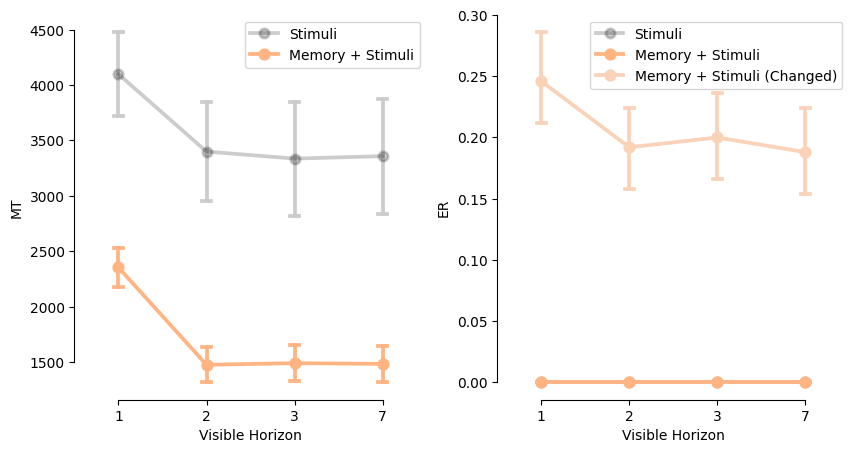

CPU times: user 30.4 s, sys: 1.4 s, total: 31.8 s
Wall time: 30.2 s


In [233]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

fig, axs = plt.subplots(1,2, figsize = (10,5))

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, random_seq)]
        if check_evidence_to_seq(evidence, random_seq):
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]
        

sns.pointplot(data=ER, x='windowSize', y='ER', errorbar='sd', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[1])
sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[0])
ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'unchanged'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq)]
        if check_evidence_to_seq(evidence, specific_seq):
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]


sns.pointplot(data=ER, x='windowSize', y='ER', errorbar='sd', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[1])
sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[0])
ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'changed'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
num_sims = 500
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
        if check_evidence_to_seq(evidence, specific_seq):
            MT.loc[len(MT)] = [window, sum(IPIs[1:])]

# sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[0])
sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[1])



model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

for ax in axs:
    ax.set_xlabel('Visible Horizon')
    ax.set_xticks(range(len(window_sizes)))
    ax.set_xticklabels(window_sizes)


# legend labels

plt.legend(loc='upper right')

# plt.legend()
sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_Random_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


In [248]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols


trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'changed'
ER = pd.DataFrame(columns = ['windowSize', 'pressError'])
num_sims = 50
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        for press in range(len(seq)):
            if ~(np.argmax(evidence[:, press]) + 1 == int(specific_seq_changed_one_digit[press])):
                ER.loc[len(ER)] = [window, press]
                break




CPU times: user 1.58 s, sys: 37.4 ms, total: 1.62 s
Wall time: 1.65 s


In [245]:
ER

,windowSize,pressError
0,1,3
1,1,3
2,1,3
3,1,3
4,1,3
...,...,...
152,7,3
153,7,3
154,7,3
155,7,3


# Testing for different Betas

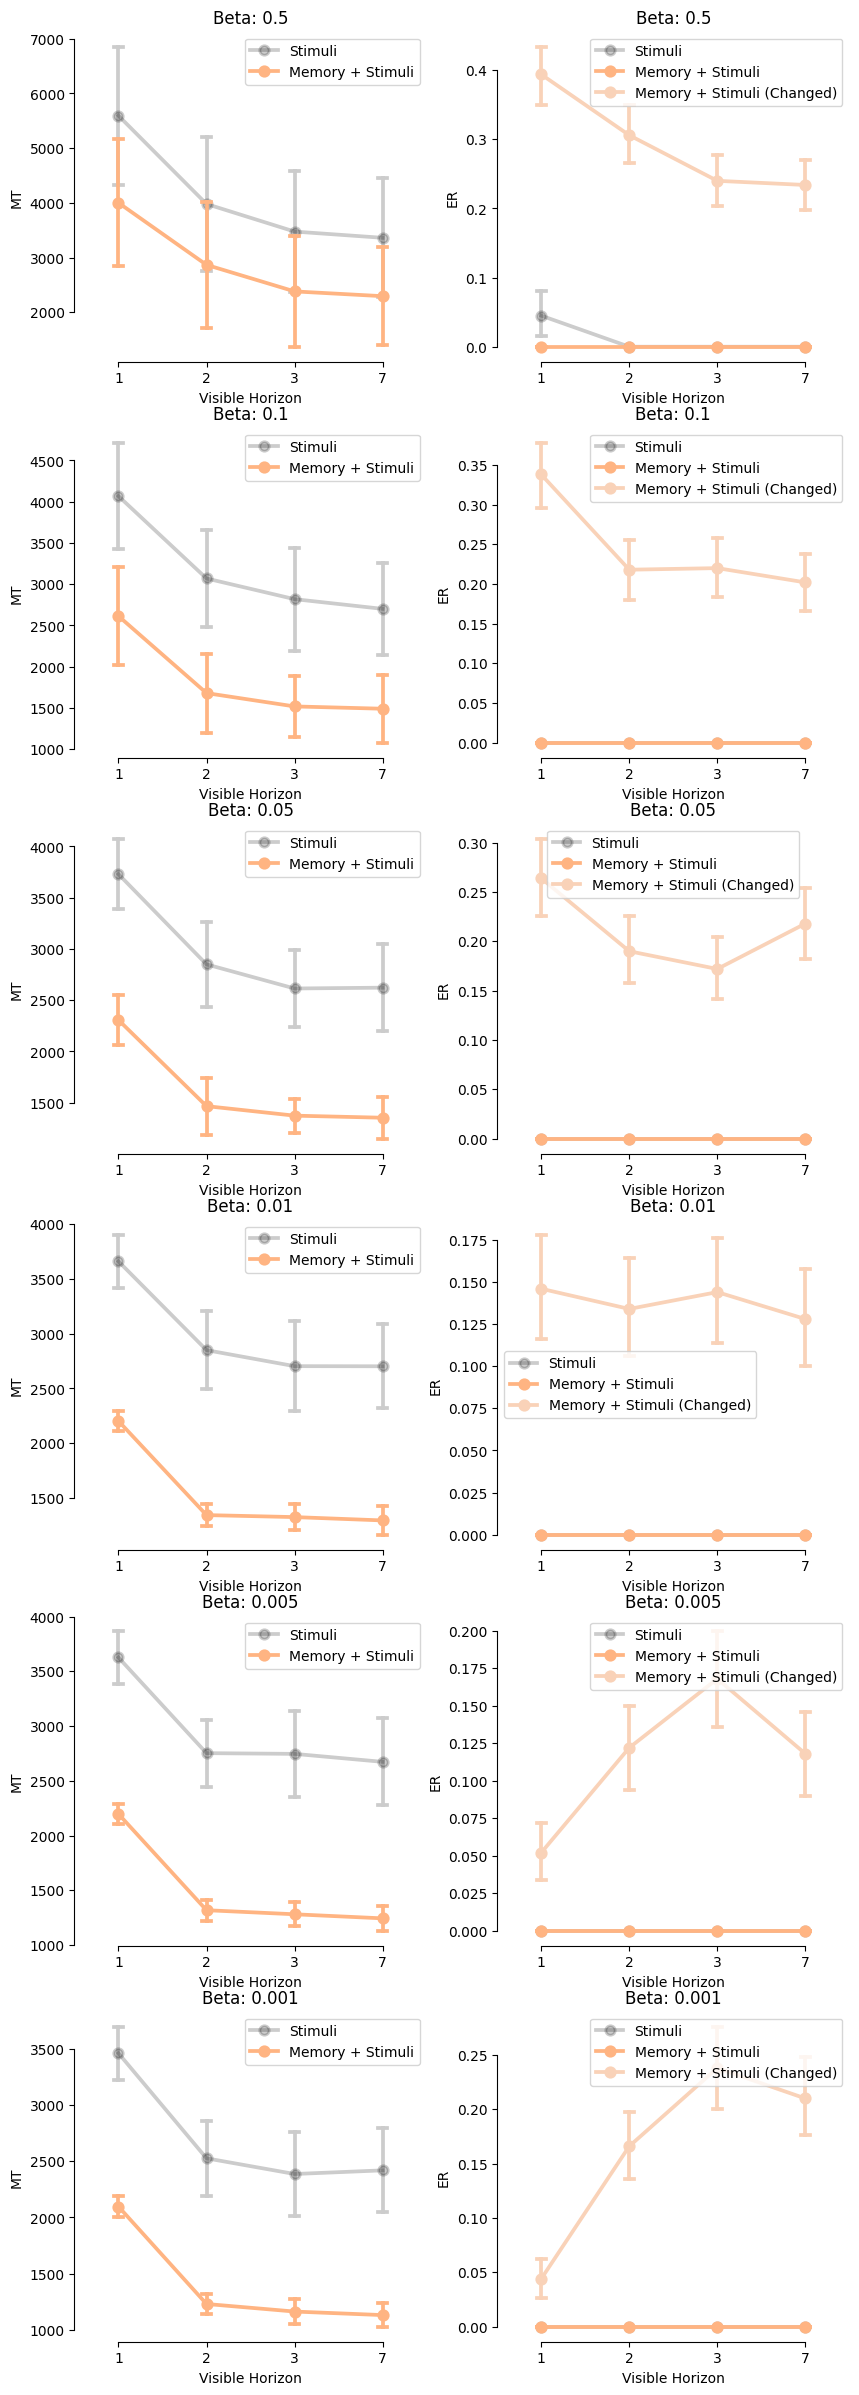

CPU times: user 2min 52s, sys: 1.5 s, total: 2min 53s
Wall time: 2min 55s


In [281]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

betas = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

fig, axs = plt.subplots(len(betas), 2, figsize = (10, 5 * len(betas)))



trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for plt_idx, beta in enumerate(betas):

    num_sims = 200

    visual_drifts = calc_visual_drifts(random_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'rand'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
        diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
        planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, random_seq)]
            if check_evidence_to_seq(evidence, random_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]
            

    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])
    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 0])


    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'unchanged'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    num_sims = 200
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]


    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])
    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 0])


    visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'changed'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    num_sims = 500
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    # sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[0])
    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])

    for ax in axs[plt_idx]:
        ax.set_xlabel('Visible Horizon')
        ax.set_xticks(range(len(window_sizes)))
        ax.set_xticklabels(window_sizes)
        ax.set_title(f'Beta: {beta}')


# legend labels

plt.legend(loc='upper right')

sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_Random_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


# Testing for different alphas

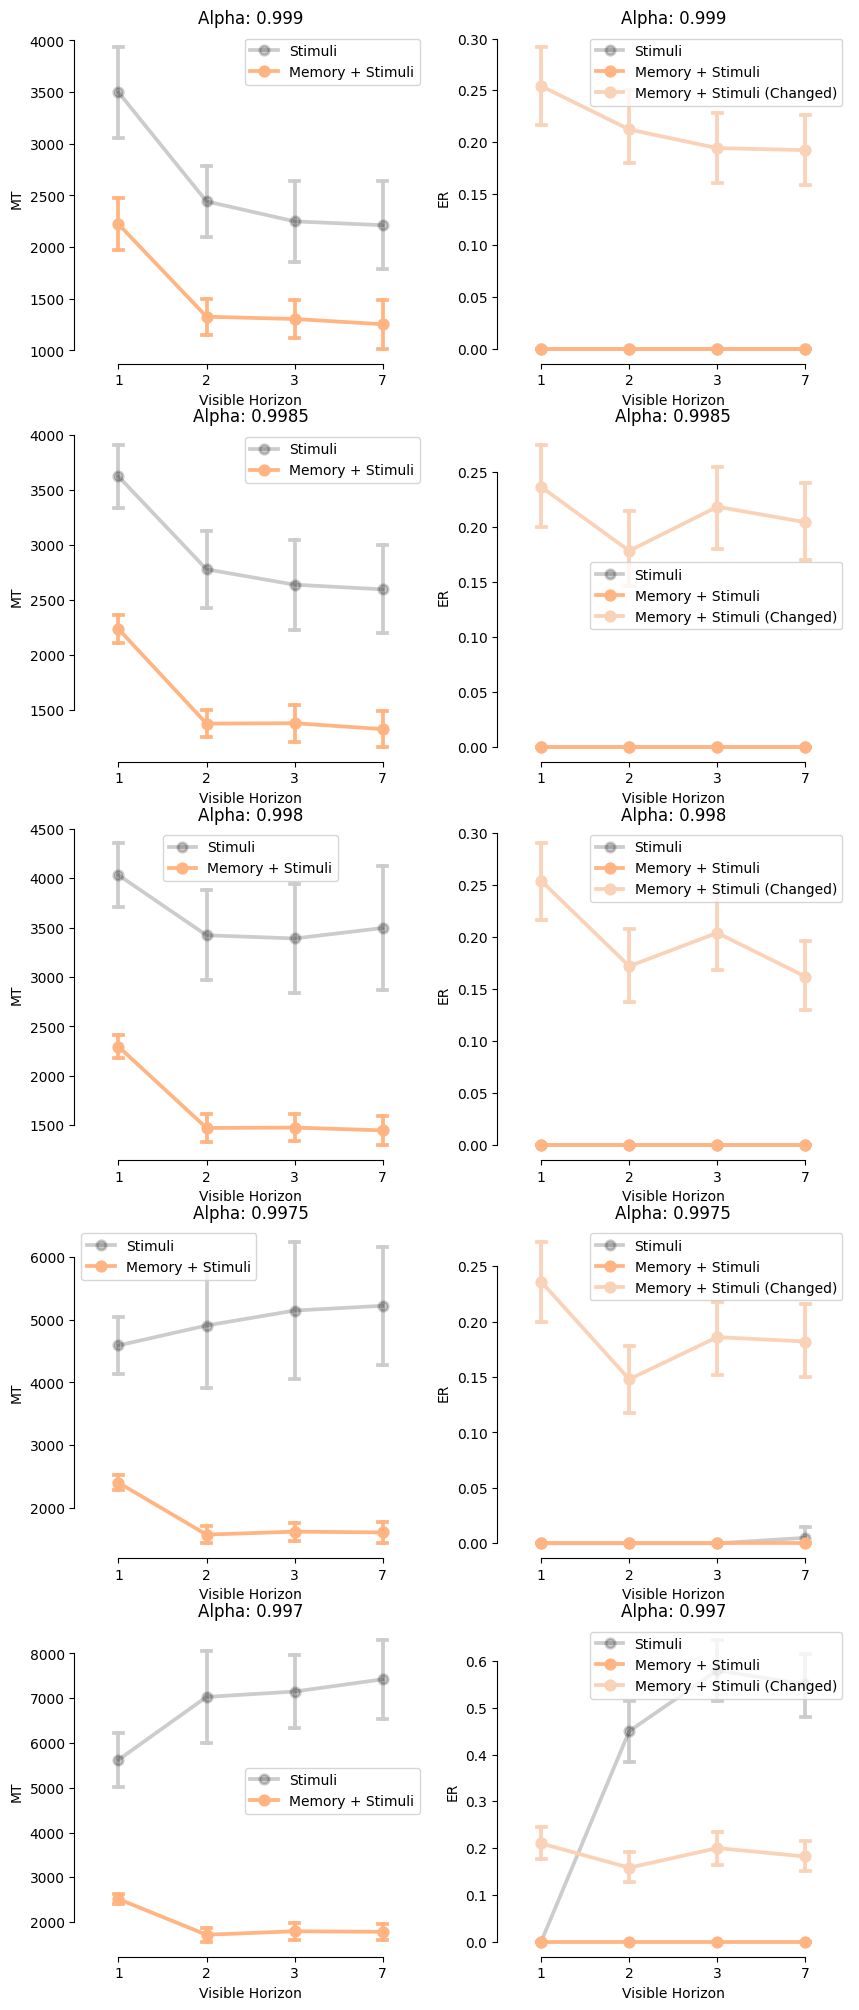

CPU times: user 2min 49s, sys: 1.88 s, total: 2min 51s
Wall time: 2min 52s


In [265]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

beta = 0.03
# alpha = 0.9985


alphas = [0.999,0.9985, 0.998, 0.9975, 0.997]

fig, axs = plt.subplots(len(alphas), 2, figsize = (10, 5 * len(alphas)))



trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for plt_idx, alpha in enumerate(alphas):

    num_sims = 200

    visual_drifts = calc_visual_drifts(random_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'rand'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
        diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
        planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, random_seq)]
            if check_evidence_to_seq(evidence, random_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]
            

    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])
    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 0])


    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'unchanged'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    num_sims = 200
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]


    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])
    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 0])


    visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'changed'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    num_sims = 500
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    # sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[0])
    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])

    for ax in axs[plt_idx]:
        ax.set_xlabel('Visible Horizon')
        ax.set_xticks(range(len(window_sizes)))
        ax.set_xticklabels(window_sizes)
        ax.set_title(f'Alpha: {alpha}') 



# legend labels

plt.legend(loc='upper right')

sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_Random_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


## Trial Examples:

****** Window Size:  1  ******


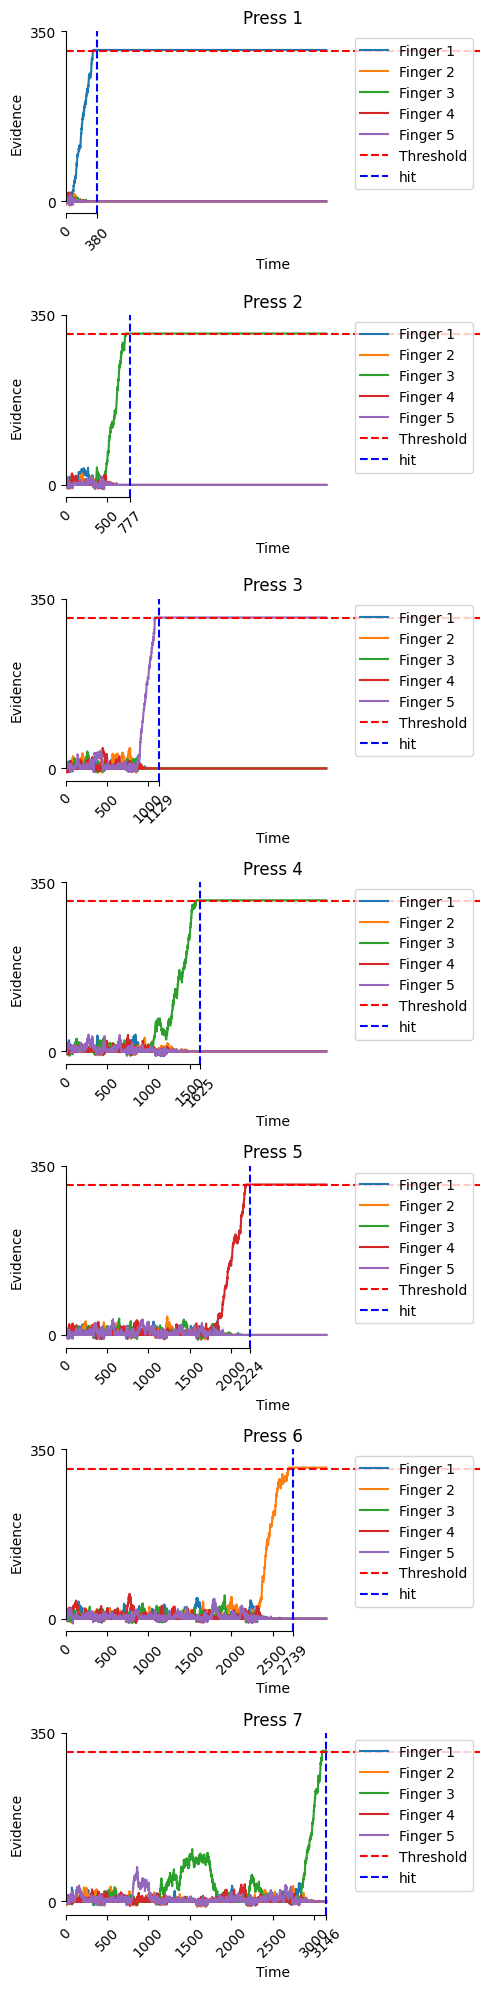

****** Window Size:  2  ******


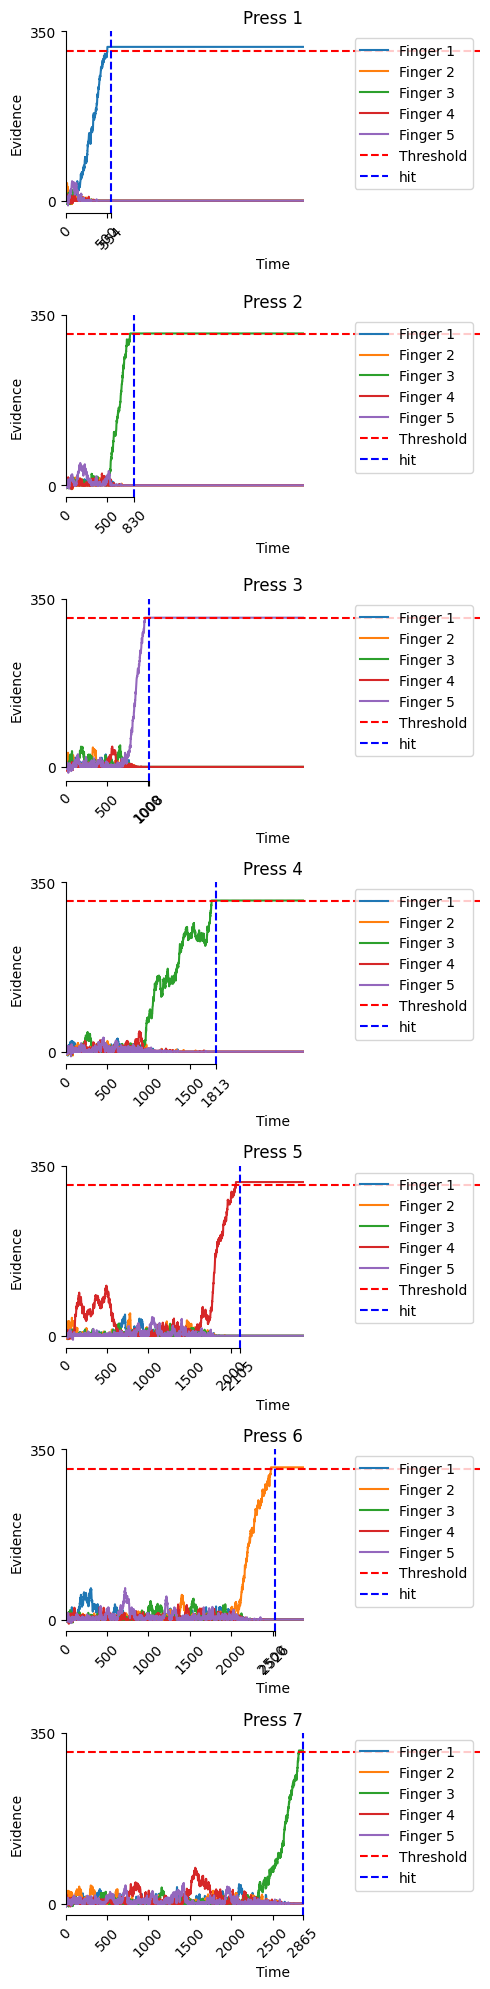

****** Window Size:  3  ******


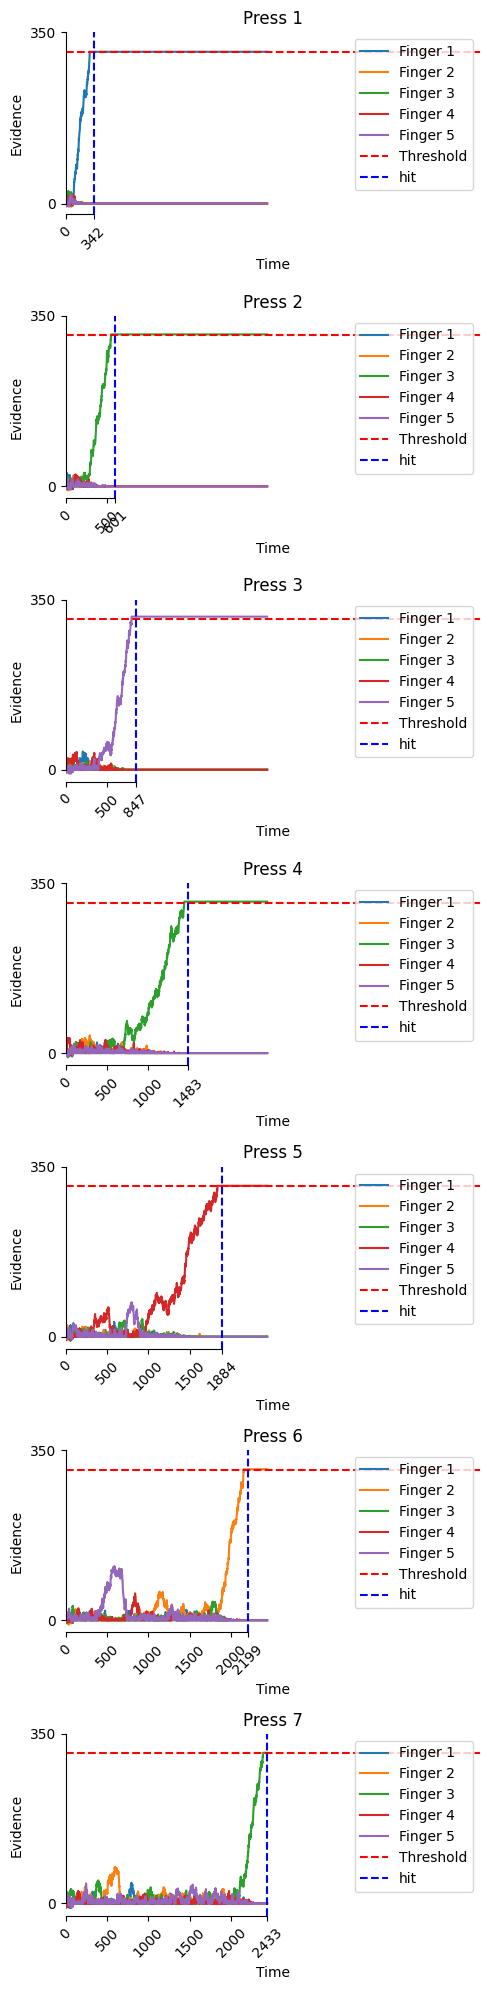

****** Window Size:  7  ******


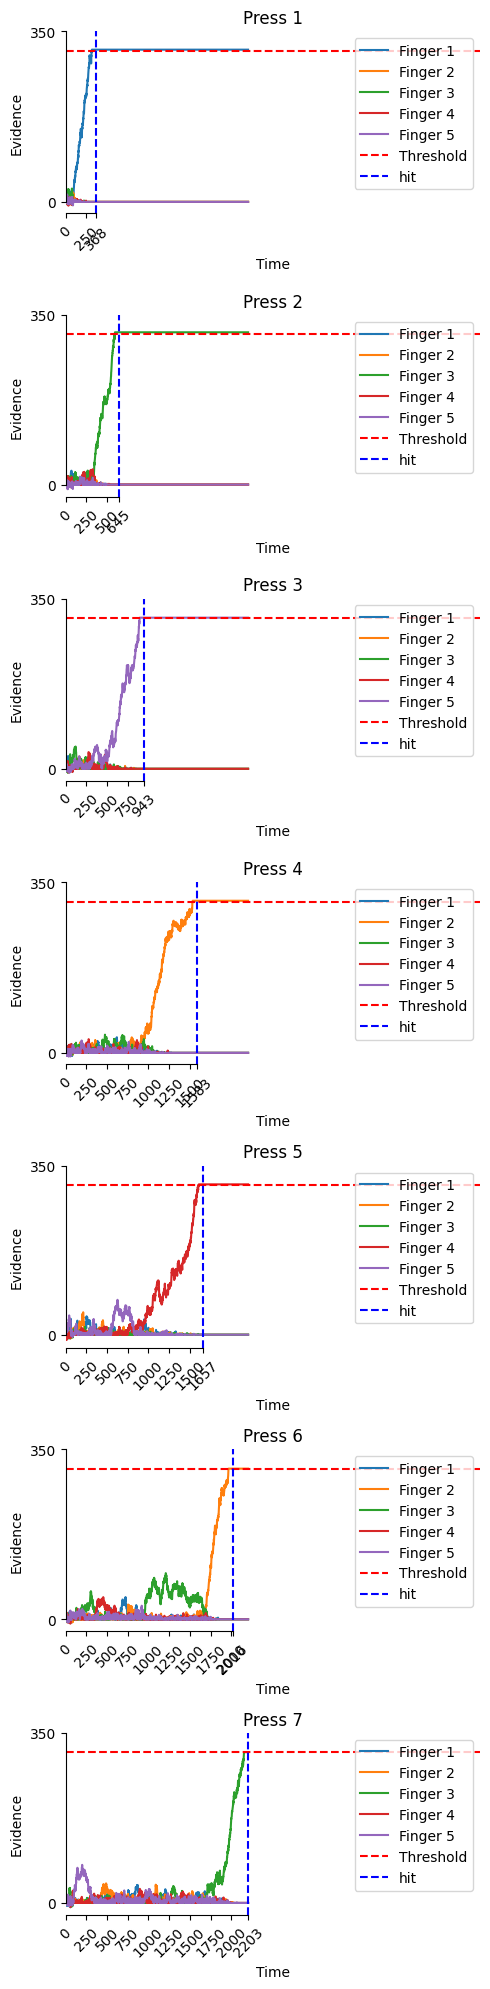

In [270]:
alpha = 0.9985
beta = 0.03
visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'changed'
for window in window_sizes:
    print("****** Window Size: ", window, " ******")
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param
    ,alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    fig , axs = model.plot_simulations()
    fig.suptitle(f'Window Size: {window}  Seq: {specific_seq_changed_one_digit}')

    for ax in axs:
        ax.set_ylim([0, 100])
    
    #common legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    # for _ in range(num_sims):
    #     IPIs, evidence = model.simulate()
    #     ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
    #     if check_evidence_to_seq(evidence, specific_seq):
    #         MT.loc[len(MT)] = [window, sum(IPIs[1:])]

****** Window Size:  1  ******


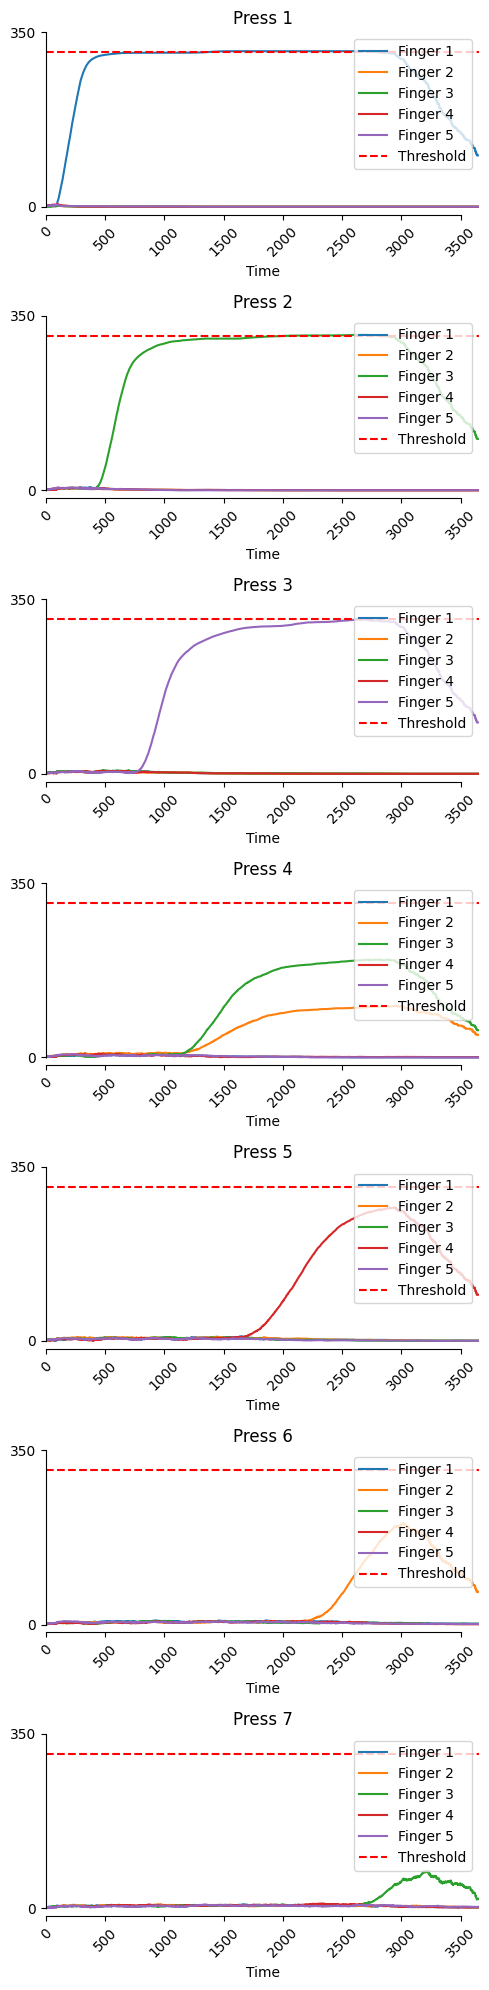

****** Window Size:  2  ******


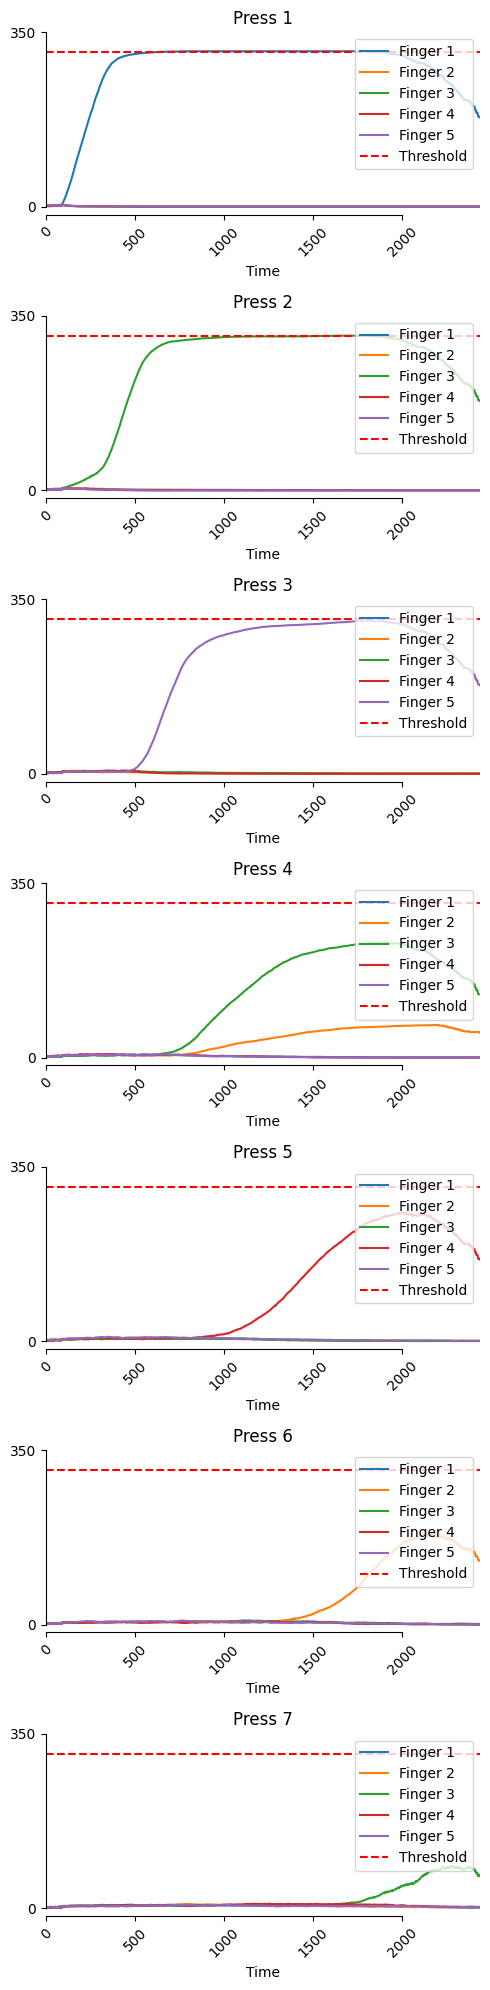

****** Window Size:  3  ******


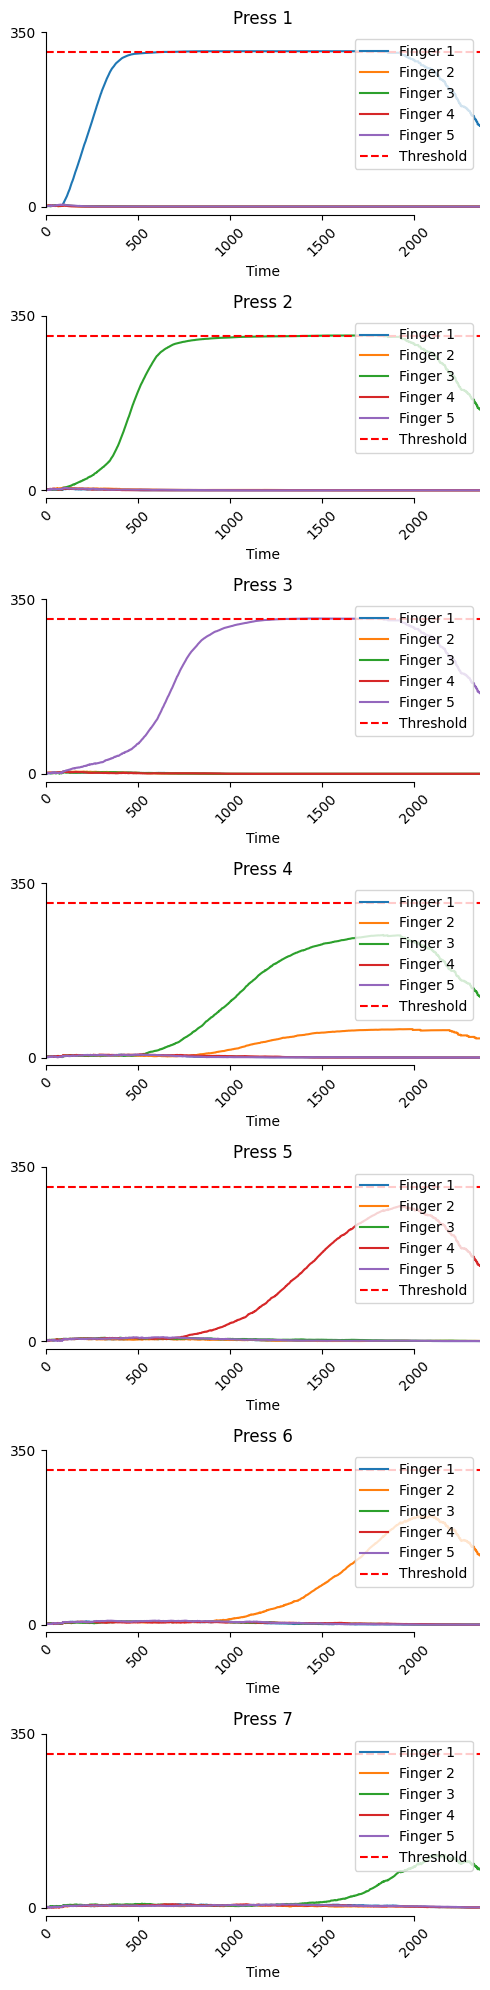

****** Window Size:  7  ******


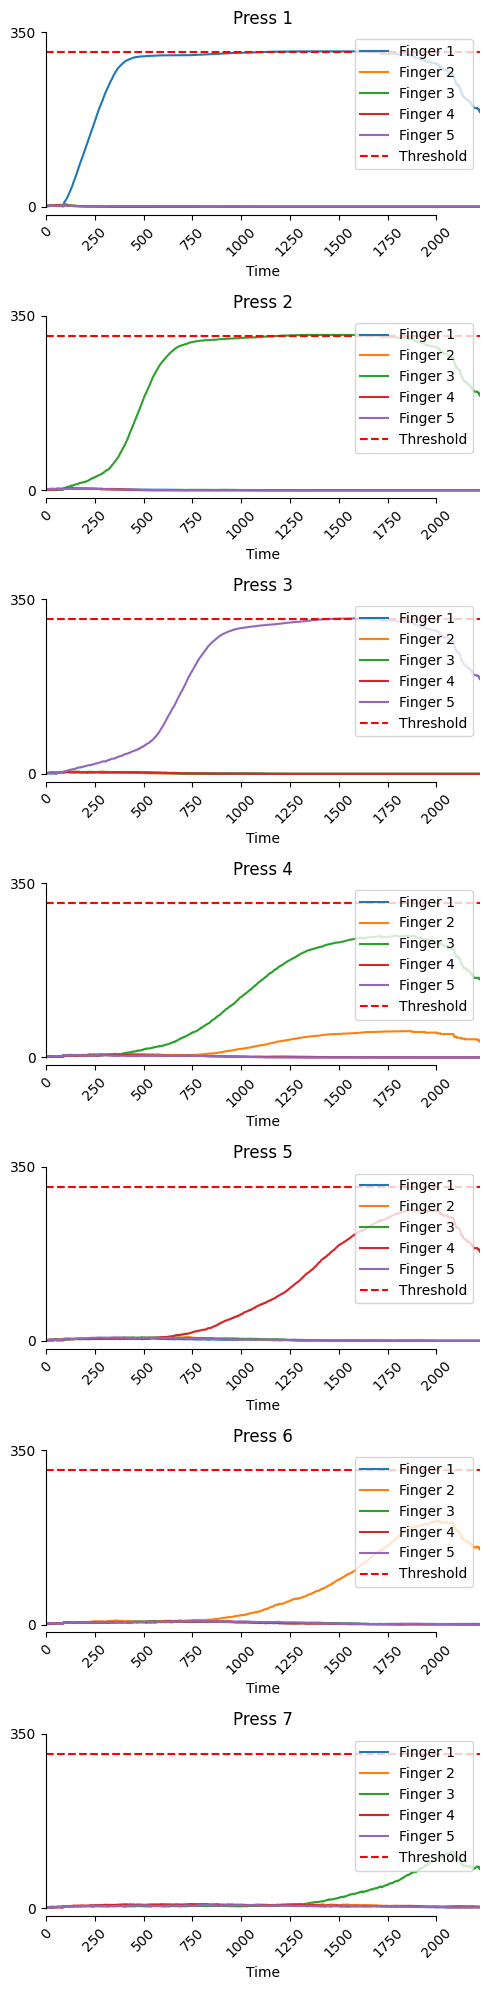

In [276]:
alpha = 0.9985
beta = 0.1
visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'changed'
for window in window_sizes:
    print("****** Window Size: ", window, " ******")
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    fig, axs = model.plot_average_simulations(200)
    fig.suptitle(f'Window Size: {window}  Seq: {specific_seq_changed_one_digit}')

    # for ax in axs:
    #     ax.set_ylim([0, 100])
    
    #common legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    # for _ in range(num_sims):
    #     IPIs, evidence = model.simulate()
    #     ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
    #     if check_evidence_to_seq(evidence, specific_seq):
    #         MT.loc[len(MT)] = [window, sum(IPIs[1:])]